In [1]:
import sys
import os
sys.path.append('..')
from adjoint_nn.dynamical_systems import Lorenz63
import adjoint_nn.solve_ode as solve_ode
import numpy as np
import matplotlib.pyplot as plt
from adjoint_nn.esn import ESN

In [2]:
# run lorenz system
my_lorenz63 = Lorenz63(beta=8/3, rho=28, sigma=10, t_lyap=0.906**(-1))

dt = 1e-2

t_transient_len = 200
t_washout_len = 2
t_train_len = 50*my_lorenz63.t_lyap
t_val_len = 5*my_lorenz63.t_lyap
t_sim_len = t_transient_len+t_washout_len+t_train_len+t_val_len

upsample = 2
t_sim = np.arange(0,t_sim_len,dt/upsample)
rnd = np.random.RandomState(seed = 6)
u0 = rnd.random((my_lorenz63.N_dim)) 
U_sim = solve_ode.integrate(my_lorenz63, u0, t_sim, integrator='forward_euler')

# upsample
U = U_sim[::upsample,:]
t = t_sim[::upsample]

# cut the transient    
N_transient = int(np.round(t_transient_len/dt))
U = U[N_transient:,:]

# separate into washout, train, val
N_washout = int(np.round(t_washout_len/dt))
N_train = int(np.round(t_train_len/dt))
N_val = int(np.round(t_val_len/dt))

U_washout = U[0:N_washout,:]

U_train = U[N_washout:N_washout+N_train-1,:]
Y_train = U[N_washout+1:N_washout+N_train,:]
t_train = t[N_washout+1:N_washout+N_train]

U_val = U[N_washout+N_train:N_washout+N_train+N_val-1,:]
Y_val = U[N_washout+N_train+1:N_washout+N_train+N_val,:]
t_val = t[N_washout+N_train+1:N_washout+N_train+N_val]

Running solver.


In [3]:
U_data = U[:N_washout+N_train]
U_mean = U_data.mean(axis = 0)
U_std = U_data.std(axis = 0)
m = U_data.min(axis=0)
M = U_data.max(axis=0)
U_norm = M-m 
scale = (U_mean, U_std)

In [4]:
bias_in = np.array([np.mean(np.abs((U_data-scale[0])/scale[1]))])
my_ESN = ESN(reservoir_size = 200, dimension = my_lorenz63.N_dim, connectivity = 3, 
                input_scaling = 0.3, spectral_radius = 0.5,
                leak_factor = 1.0, tikhonov = 1e-12, bias_in = bias_in)

In [5]:
my_ESN.train(U_washout, U_train, Y_train, scale)

In [6]:
# Wash-out phase to get rid of the effects of reservoir states initialised as zero
x0_washout = np.zeros(my_ESN.N_reservoir) # initialise the reservoir states before washout

# let the ESN run in open-loop for the wash-out
# get the initial reservoir for the training, which is the last reservoir state
x0 = my_ESN.open_loop(x0=x0_washout, U=U_washout, scale = scale)[-1,:] 
X_pred, Y_pred = my_ESN.closed_loop(x0 = x0, N_t = N_train+N_val-2, scale = scale)
Y_pred_train = Y_pred[1:N_train,:]
Y_pred_val = Y_pred[N_train-1:-1,:]

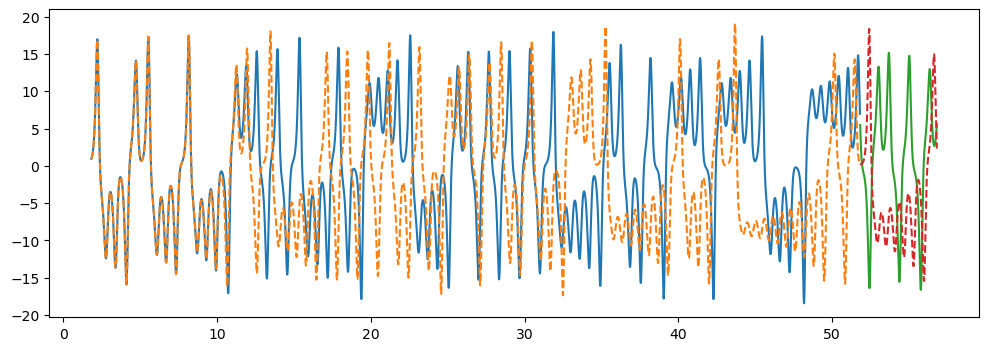

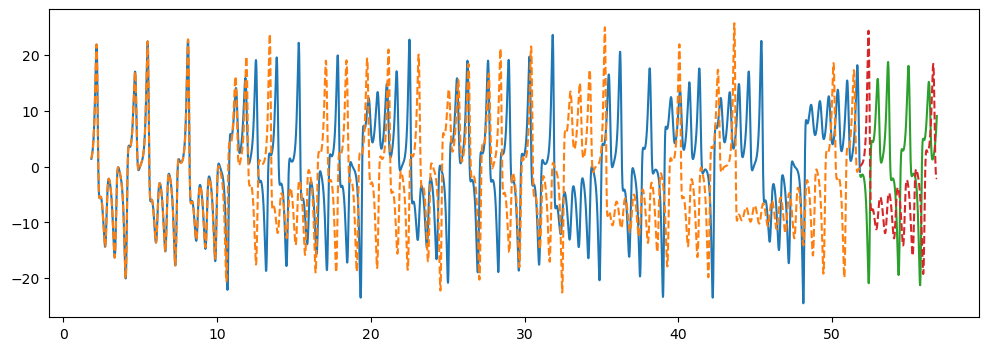

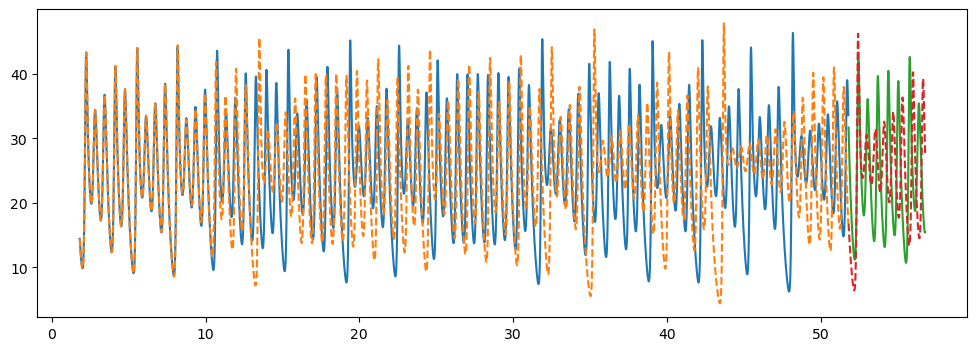

In [7]:
for j in range(my_lorenz63.N_dim):
    plt.figure(figsize=(12,4))
    plt.plot(t_train/my_lorenz63.t_lyap, Y_train[:,j])
    plt.plot(t_train/my_lorenz63.t_lyap, Y_pred_train[:,j],'--')
    plt.plot(t_val/my_lorenz63.t_lyap, Y_val[:,j])
    plt.plot(t_val/my_lorenz63.t_lyap, Y_pred_val[:,j],'--')